In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

<figure id="figure-3">
<div style="background-color: white">

![](figures/dct.svg)</div>
    
<figcaption style="text-align: center">Figure 3: A DCT can be treated as an N channel filter bank where the coefficients of the
filters are the basis functions.</figcaption></figure>

# 7 The Discrete Cosine Transform (DCT)


The DCT is a method of performing energy compaction that is rather different
from the pyramid method.  It operates on non-overlapping blocks of pixels
(typically $8 \times 8$ pixels in size) by a reversible linear transform
process, such that each block of pixels is replaced by a block of the same
number of transform coefficients.  If all the transform coefficients for a
given block are transmitted unaltered to the decoder, then the original block
of pixels can be exactly recovered by the inverse transform process.

In practise the transform coefficients are quantised before transmission, and
if energy compaction has occurred, then fewer bits will be needed to send the
coefficients than the original pixels.  A key advantage of transform-based
methods is that there is no expansion of the number of samples (the
transformed block is the same size as the original block of pixels), whereas
the previous pyramid method expands the data by
$1 + \frac{1}{4} + \frac{1}{16} + \ldots \approx 1.33$ times, which is not very desirable for data
compression.

## 7.1 Definition of the DCT


The one-dimensional form of the DCT is closely related to the Discrete Fourier
Transform (DFT).  The 1-D $N$-point DCT is defined as follows:


$$
y(k) = \sum_{n=0}^{N-1} C_{kn}\ x(n) \quad \text{for} \quad 0 \le k \le N-1 \\
  \text{where }\quad C_{0n} = \sqrt{\frac{1}{N}}  \\
    \text{and } \quad C_{kn} = \sqrt{\frac{2}{N}}\ \cos
\frac{k(n+\frac{1}{2})\pi}{N} \quad \text{for} \quad 1 \le k \le N-1
$$

The equivalent inverse DCT is:
$$
x(n) = \sum_{k=0}^{N-1} C_{kn}\ y(k) \quad \text{for} \quad 0 \le n \le N-1 \\
 \text{where $C_{kn}$ is defined as above.}\\
$$

(This is actually the Type-II DCT, and the inverse is the Type-III DCT - other types have slightly different relative phases})

We see that the forward transform is equivalent to multiplication of the
$N$-point column vector $[x(0) \ldots x(N-1)]'$ by an $N \times N$ matrix,
containing $C_{kn}$ at each location $(k,n)$, to produce the $N$-point column
vector $[y(0) \ldots y(N-1)]'$.  Similarly the inverse transform is equivalent
to multiplication of the $y$ vector by the transpose of the $C$ matrix to give
the $x$ vector.  In python3 + numpy notation these become:

`y = C @ x` and `x = C.T @ y`

Note that C is an orthonormal matrix since its inverse is just its
transpose (its rows are othogonal to each other and have unit energy).

The two-dimensional version of the DCT (as used for image compression) is a
simple extension of the above 1-D DCT.  For an $N \times N$ block of pixels,
the $N$-point 1-D DCT is first applied to each column of the block to give $N$
columns of coefficients.  Then the same 1-D DCT is applied to the rows of
these coefficients to give the 2-D transform coefficients.

In python3 + numpy notation, if the input block of pixels is matrix X, the output
block of 2-D transformed coefficients Y is given by:

`Y = (C @ (C @ X).T).T` or more simply `Y = C @ X @ C.T`

where C is the 1-D transform matrix as above.  Note that in the 2-D
transform, it does not matter whether the rows or the columns are transformed
first (because the transform is linear and separable).


## 7.2 Applying the DCT to images

Conceptually the 2-D DCT is applied to all non-overlapping $N \times N$ blocks
of pixels in an image (we assume that the image dimensions are exact multiples
of $N$).  However it is simplest and most efficient to perform 1-D
$N$-point DCTs on all the columns of the image first, and then repeat the
operation on the transpose of the result to transform the rows.

**First generate an 8-point 1-D Type-II DCT matrix C8**

In [2]:
from cued_sf2_lab.dct import dct_ii

C8 = dct_ii(8)

Take a look at the function `dct_ii` and list `C8` to check
that it agrees with the definitions for $C_{kn}$ given above:

In [3]:
import inspect
import IPython.display
IPython.display.Code(inspect.getsource(dct_ii), language="python")

def dct_ii(N: int) -> np.ndarray:
    """
    Generate the 1D DCT transform matrix of size N.

    Parameters:
    N (int): Size of DCT matrix required

    Returns:
    C (2D np array): 1D DCT transform matrix

    Uses an orthogonal Type-II DCT.
    Y = C * X tranforms N-vector X into Y.
    """
    C = np.ones((N, N)) / np.sqrt(N)
    theta = (np.arange(N) + 0.5) * (np.pi/N)
    g = np.sqrt(2/N)
    for i in range(1, N):
        C[i, :] = g * np.cos(theta*i)

    return C

**Plot the rows of `C8` using `plot(C8.T)`.**

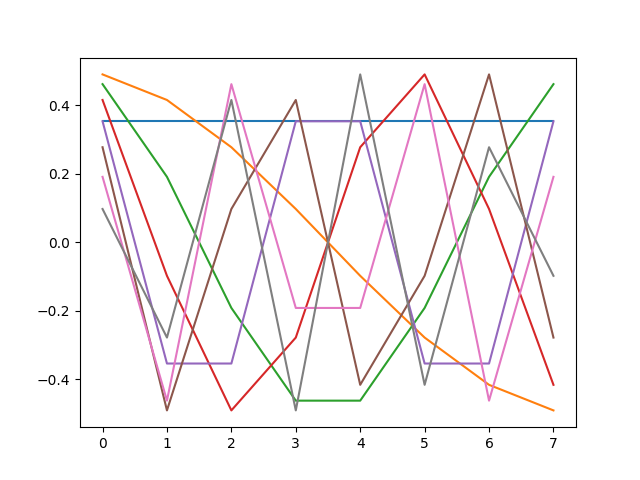

In [4]:
fig, ax = plt.subplots()
ax.plot(C8.T);


When we calculate the 1-D transform of an 8-point block of data, each
transform coefficient represents the component of the data that is
correlated with the corresponding row of `C8`.  Hence the
first coefficient represents the dc component, the second one
represents the approximate average slope, and so on. The later
coefficients represent progressively higher frequency components
in the data.

The function `colxfm(X, C8)` will perform a 1-D transform on
the columns of image `X` using `C8`. We can
therefore perform a 2-D transform on `X` by using `colxfm` twice, once with transpose operators, as follows:

In [5]:
from cued_sf2_lab.familiarisation import load_mat_img
from cued_sf2_lab.dct import colxfm

X_pre_zero_mean, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X_pre_zero_mean - 128.0

Y = colxfm(colxfm(X, C8).T, C8).T

In `Y`, each $8 \times 8$ block of pixels has been replaced by an
equivalent block of transform coefficients.  The coefficient in the top left
corner of each block represents the dc value of the block of pixels;
coefficients along the top row represent increasing horizontal frequency
components, and along the left column represent increasing vertical frequency
components.  Other coefficients represent various combinations of horizontal
and vertical frequencies, in proportion to their horizontal and vertical
distances from the top left corner.

If we try to display `Y` directly as an image, it is rather
confusing because the different frequency components of each block
are all present adjacent to each other.  

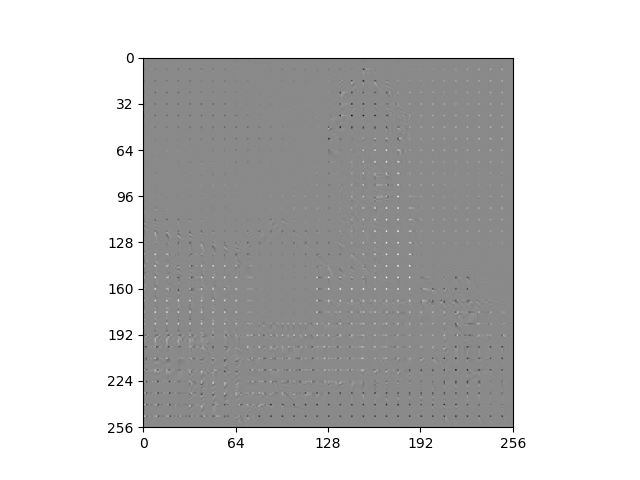

In [6]:
from cued_sf2_lab.familiarisation import plot_image

fig, ax = plt.subplots()
plot_image(Y, ax=ax);

A much more meaningful
image is created if we group all the coefficients of a given type
together into a small sub-image, and display the result as an $8
\times 8$ block of sub-images, one for each coefficient type.  The
function `regroup(Y, N)` achieves this regrouping, where $N$ is
the size of the original transform blocks. You need to ensure that X has zero mean (by subtracting 128) before you start transforming it, otherwise the dc coefficient will be purely positive, whereas the
others are symmetrically distributed about zero. Also, an $N
\times N$ 2-D DCT introduces a gain factor of $N$ in order to
preserve constant total energy between the pixel and transform
domains: we need to divide by $N$ *when displaying* to get back to the expected range.

Hence we can display `Y` meaningfully using:

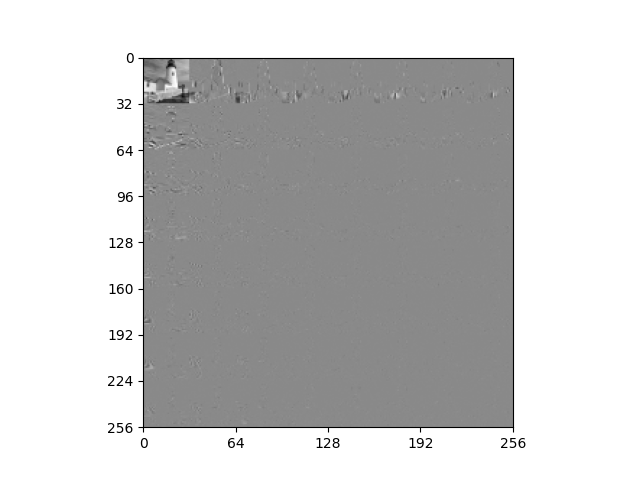

In [7]:
from cued_sf2_lab.dct import regroup

N = 8
fig, ax = plt.subplots()
plot_image(regroup(Y, N)/N, ax=ax);

In this image, you should see a small replica of the original in the top left
corner (the dc coefficients), and other sub-images showing various edges from
the original, representing progressively higher frequencies as you move
towards the lower right corner.

<div class="alert alert-block alert-danger">

What do you observe about the energies of the sub-images as frequencies
increase?</div>

(256, 256)
1,768,561   119,372    89,712    43,284    39,788    40,546    23,534    19,816
  152,570    29,150    12,312     7,350     5,012     4,286     3,326     3,943
   46,750    15,289     5,508     3,312     2,458     2,374     2,376     1,398
   26,696     9,223     4,410     2,329     1,382     1,252       929       851
   13,849     8,890     2,599     1,698       994       889       918       607
   17,824     6,577     2,921     1,413       941       855       653       733
   12,856     5,710     2,472       992       844       803       553       490
    4,686     3,625     2,605     1,179       773       689       469       482
(8, 8)


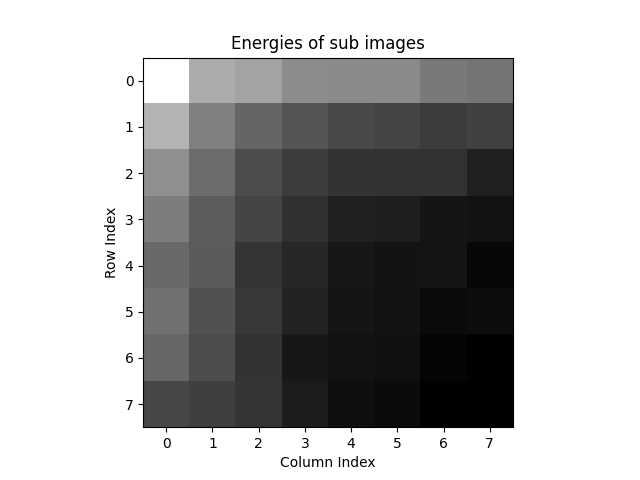

In [8]:
# E_lp = np.sum(Xf_rc**2.0)
# print('{:.2e}'.format(E_lp)) #low pass has more energy

import numpy as np

regrouped = regroup(Y, N)/N
print(regrouped.shape)

# # Final check
# is_numpy_256x256 = isinstance([regrouped], np.ndarray)

# # Print the result
# print("Is 'regrouped' a NumPy array with shape 256x256? ", is_numpy_256x256)

# Step 1: Square each element in the matrix
squared = np.square(regrouped)

# Step 2: Initialize an 8x8 matrix to hold the sums of 32x32 blocks
block_sums = np.zeros((8, 8))

# Step 3: Compute the sum for each 32x32 block
for i in range(8):
    for j in range(8):
        block = squared[i*32:(i+1)*32, j*32:(j+1)*32]
        block_sums[i, j] = np.sum(block)

# Step 4: Determine the maximum length for formatting
max_length = max(len(f"{int(value):,}") for row in block_sums for value in row)

# Step 5: Print the 8x8 matrix with formatted output, aligned numbers
for row in block_sums:
    formatted_row = [f"{int(value):>{max_length},}" for value in row]
    print(" ".join(formatted_row))



from matplotlib.colors import LogNorm


print(block_sums.shape)
# Create a heatmap in greyscale
plt.imshow(block_sums, cmap='gray',norm=LogNorm(), interpolation='nearest')
# plt.colorbar(label='Block Sum')

# Add labels to the plot
plt.title('Energies of sub images')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Show the plot
plt.show()


Now check that you can recover the original image from Y
by carrying out the inverse transform using:

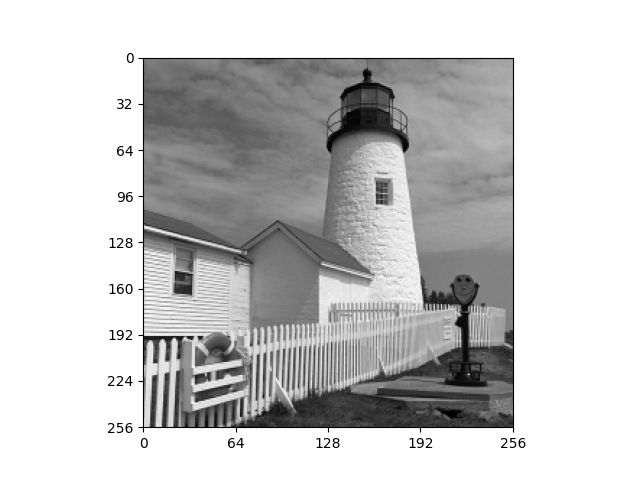

In [9]:
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

fig, ax = plt.subplots()
plot_image(Z, ax=ax);

**Measure the maximum absolute error between X and Z
to confirm this.**

In [10]:
# Your code here

max_abs_value = np.max(np.abs(X-Z))

print(f"The maximum absolute value in the array is: {max_abs_value}")

The maximum absolute value in the array is: 6.110667527536862e-13


The DCT analyses each $8 \times 8$ block of image pixels into a linear
combination of sixty-four $8 \times 8$ basis functions.  The following will generate
an image comprising these basis functions (the `np.nan`s separate the sub-images as matplotlib draws them as transparent, and the `reshape` function converts from a matrix to a row vector):

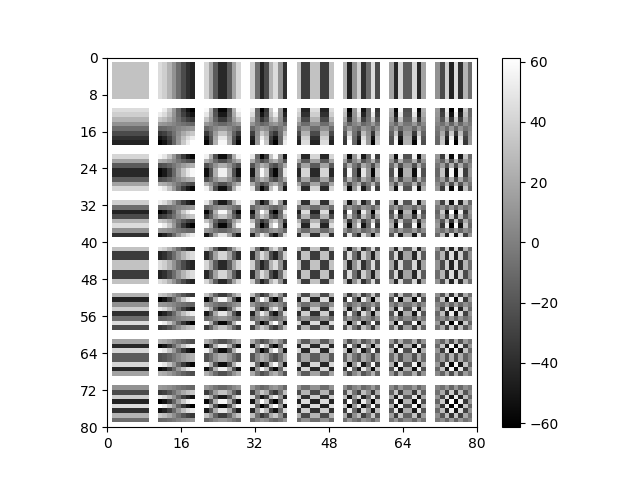

In [11]:
import numpy as np
# Stack some NaNs
bases = np.concatenate([np.full((8, 1), np.nan), C8, np.full((8, 1), np.nan)], axis=1)
# Reshape
bases_flat = np.reshape(bases, (-1, 1))

fig, ax = plt.subplots()
im = plot_image(255*bases_flat@bases_flat.T, ax=ax)
fig.colorbar(im);

<div class="alert alert-block alert-danger">

Explain how this image relates to the DCT coefficients.</div>

TODO explain
across row: ocisllations of increasing frequency
each sub picture is a basis. separate horizontal vertical frequency
dot product with original image. stride of 8

sampling of the cos causes edge effects

## 7.3 Quantisation and Coding Efficiency

We are now going to look at the effects of quantising the DCT coefficients
fairly coarsely and determine the entropies of the coefficient sub-images.
At this stage we shall quantise all sub-images with the same step-size,
since they all are the same size and have unit energy gain from the
quantiser to the output image (due to the orthonormal transform matrices).

First quantise the transformed image Y using a step size
of 17 to give Yq.  Then regroup Yq to form
sub-images of each coefficient type as before, to give Yr. These sub-images have different probability distributions and we can take advantage of this later in coding them efficiently. Hence we get a better estimate of the number of bits required to code Yq by looking at the entropies of each of the re-grouped sub-images separately.

**Write a function `dctbpp(Yr, N)` to calculate the total number of bits from a re-grouped image Yr, by using `bpp(Ys)` on each sub-image Ys of Yr, then multiplying each result by the number of pixels in the sub-image, and summing to give the total number of bits.**

In [12]:
# N = 8
# fig, ax = plt.subplots()
# plot_image(regroup(Y, N)/N, ax=ax);

In [13]:
from cued_sf2_lab.laplacian_pyramid import bpp

def dctbpp(Yr, N): #calculate total bits from regrouped image
    # Your code here
    # pass # This just does nothing at the moment
    h=Yr.shape[0]
    w=Yr.shape[1]

    block_h=int(h/N)
    block_w=int(w/N)

    # print(block_h,block_w)

    total_bits = 0

    for i in range(N):
        for j in range(N):
            block = Yr[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            total_bits = total_bits + bpp(block)*block_h*block_w
            # block_sums[i, j] = np.sum(block)

    return total_bits

N = 8


from cued_sf2_lab.laplacian_pyramid import quantise
Y_q = quantise(Y,17)
#Yr is regrouped image
Yr=regroup(Y_q, N)/N  #Yr is from quantised
# print(Yr.shape)
print(dctbpp(Yr,N))

97467.19741586194


In [14]:
# we do bpp on quantised as dct generates many decimals, so its unlikely for 2 valuees to be the same


# here we compare regrouped and non regrouiped. regrouped shouild have lower entropy

total bits using dctbpp 97467.19741586194
total bits using just bpp(Yr) 109626.49318603268
bpp of each block
        6         3         2         2         2         1         1         1
        3         2         2         1         1         1         1         1
        3         2         1         1         1         1         1         0
        2         2         1         1         1         0         0         0
        2         1         1         1         0         0         0         0
        1         1         1         1         0         0         0         0
        1         1         1         0         0         0         0         0
        1         1         1         0         0         0         0         0


'\n\nTODO: check\nsub images have less entropy as you go down the row and column?\ndont understand why directly using dctbpp on sub images results in lower entropy\nis it because within each sub image, the pixels are more similar to each other?\n\n'

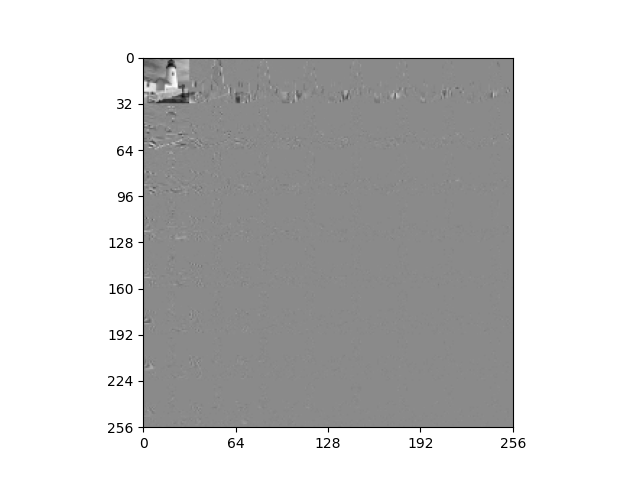

In [15]:
# Your code here

# N = 8
fig, ax = plt.subplots()
plot_image(Yr, ax=ax);
print("total bits using dctbpp",dctbpp(Yr,N))
print("total bits using just bpp(Yr)",bpp(Yr)*256**2)

block_bpp = np.zeros((8, 8))

# Step 3: Compute the sum for each 32x32 block
for i in range(8):
    for j in range(8):
        block = Yr[i*32:(i+1)*32, j*32:(j+1)*32]
        block_bpp[i, j] = bpp(block)

# Step 4: Determine the maximum length for formatting
max_length = max(len(f"{int(value):,}") for row in block_sums for value in row)

# Step 5: Print the 8x8 matrix with formatted output, aligned numbers
print("bpp of each block")
for row in block_bpp:
    formatted_row = [f"{int(value):>{max_length},}" for value in row]
    print(" ".join(formatted_row))

"""

TODO: check
sub images have less entropy as you go down the row and column?
dont understand why directly using dctbpp on sub images results in lower entropy
is it because within each sub image, the pixels are more similar to each other?

"""

<div class="alert alert-block alert-danger">

Now reconstruct the output image `Z` from `Yq` and measure the rms
error (standard deviation) between `X` and `Z`.  Compare this with the
error produced by quantising `X` with a step-size of 17 to give `Xq`.

</div>

std deviation compressed (X vs Z) 3.756757368843634
std deviation quant only (X vs Xq) 4.861168497356846


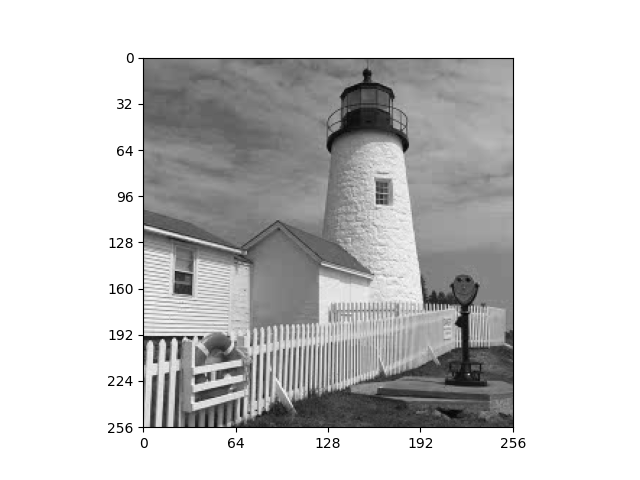

In [16]:
# Your code here
Z = colxfm(colxfm(Y_q.T, C8.T).T, C8.T)

fig, ax = plt.subplots()
plot_image(Z, ax=ax)

Xq = quantise(X,17)

# max_abs_value = np.max(np.abs(X-Z))
# print(f"The maximum absolute value in the array is: {max_abs_value}")
print("std deviation compressed (X vs Z)",np.std(X-Z))
print("std deviation quant only (X vs Xq)",np.std(X-Xq))

# TODO check if compressed is supposed to have a lower sandard error

#image looks fairly good, can see some blocking artefacts in the sky

***As with the Laplacian Pyramid, we really need to contrast compression ratios and visual results on compressed images with the same rms error. Re-use your step optimisation code to calculate the (non-integer) step size required in this case for the same rms error as quantising X with a step-size of 17.***

In [17]:
# Your code here 

def f(step_size):
    Z = colxfm(colxfm(quantise(Y, step_size).T, C8.T).T, C8.T)
    return abs(np.std(X-Xq)-np.std(X-Z))


decimal_range = np.arange(0, 40, 0.1)
optimal_step = -1
smallest_diff = 10e15

for i in decimal_range:
    # print(i,"             ",abs(f(i)))
    if f(i) < smallest_diff:
        smallest_diff = f(i)
        optimal_step = i

print("optimal_step",optimal_step)

optimal_step 23.700000000000003


<div class="alert alert-block alert-danger">

Calculate the compression ratio for this scheme compared to direct quantisation. Use `dctbpp` to calculate the number of bits needed. Contrast the visual appearance of the DCT-compressed image, the directly quantised image, and the original image.

</div>

compression ratio vs direct quantisation 2.943203081702647


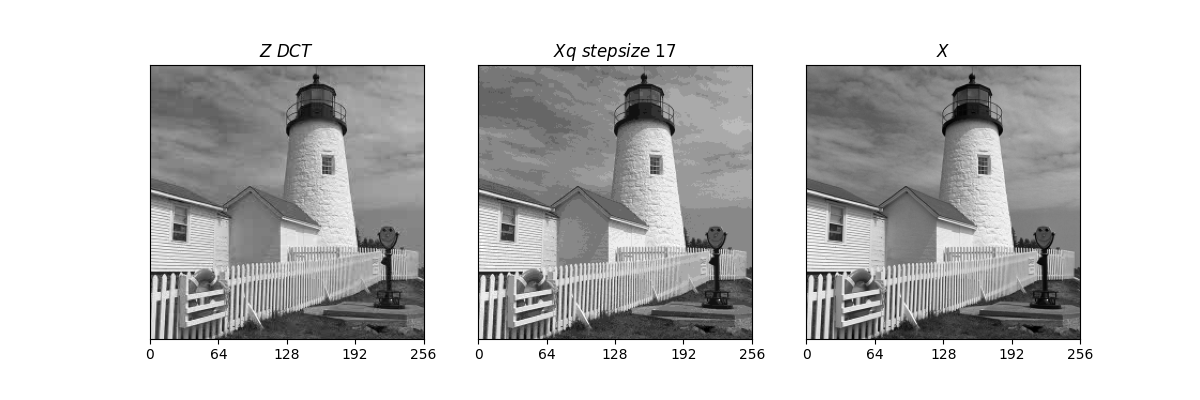

In [18]:
# Your code here

X_q_total_bits = bpp(quantise(X,17))*X.shape[0]*X.shape[1]

Y_q = quantise(Y,optimal_step)
Yr=regroup(Y_q, N)/N  #Yr is from quantised


compression_ratio = X_q_total_bits/(dctbpp(Yr,8)) #Yr is quantised
print("compression ratio vs direct quantisation",compression_ratio)

Z = colxfm(colxfm(Y_q.T, C8.T).T, C8.T)

X_q = quantise(X,17)

titles = ["Z\ DCT","Xq\ stepsize\ 17","X"]
imgs = [Z,X_q,X]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), #12 is width
                        gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs]))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

compression_ratio_dict = {}
compression_ratio_dctN_fixed = {}
compression_ratio_dict[8] = compression_ratio
compression_ratio_dctN_fixed[8] = compression_ratio

# what we are quantising is the coefficients
# small coefficients of basis functions are approximated to 0. visually this is more noticieable. some texture becomes no texture

# some noisiness near sharp edges like near the binoculars. noise looks like basis function.




## 7.4 Alternative transform sizes

So far, we have concentrated on $8 \times 8$ DCTs using C8
as the 1-D transform matrix.  **Now generate 4-point and 16-point
transform matrices, C4 and C16 using `dct_ii`.**


In [19]:
# Your code here

C4 = dct_ii(4)
C16 = dct_ii(16)

<div class="alert alert-block alert-danger">

Repeat the main measurements from the previous section, so as to obtain
estimates of the number of bits and compression ratios for $4 \times 4$ and $16 \times 16$ DCTs when the
rms errors are equivalent to those in your previous tests.  Also assess the
relative subjective quality of the reconstructed images.</div>

optimal_step 23.900000000000002
total bits using dctbpp 86221.9134494515
compression ratio 2.6457199497483272


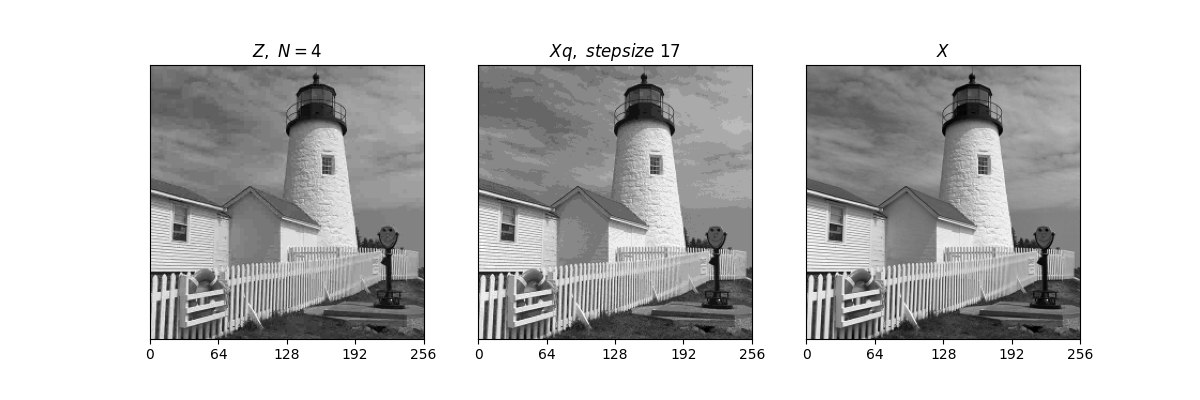

In [20]:
Y = colxfm(colxfm(X, C4).T, C4).T

N = 4

def f(step_size):
    Z = colxfm(colxfm(quantise(Y, step_size).T, C4.T).T, C4.T)
    return abs(np.std(X-Xq)-np.std(X-Z))

decimal_range = np.arange(0, 40, 0.1)
optimal_step = -1
smallest_diff = 10e15

for i in decimal_range:
    # print(i,"             ",abs(f(i)))
    if f(i) < smallest_diff:
        smallest_diff = f(i)
        optimal_step = i

print("optimal_step",optimal_step)
Y_q = quantise(Y,optimal_step)
Yr=regroup(Y_q, N)/N  #Yr is from quantised
print("total bits using dctbpp",dctbpp(Yr,N))

compression_ratio = X_q_total_bits/(dctbpp(Yr,N)) #Yr is quantised. this is variable coding N=4 here
print("compression ratio",compression_ratio)

Z = colxfm(colxfm(Y_q.T, C4.T).T, C4.T)

titles = ["Z,\ N=4","Xq,\ stepsize\ 17","X"]
imgs = [Z,X_q,X]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), #12 is width
                        gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs]))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

compression_ratio_dict[N] = compression_ratio
compression_ratio_dctN_fixed[N] = X_q_total_bits/(dctbpp(Yr,8))


optimal_step 22.3
total bits using dctbpp 79264.55564356336
compression ratio 2.877945062159845


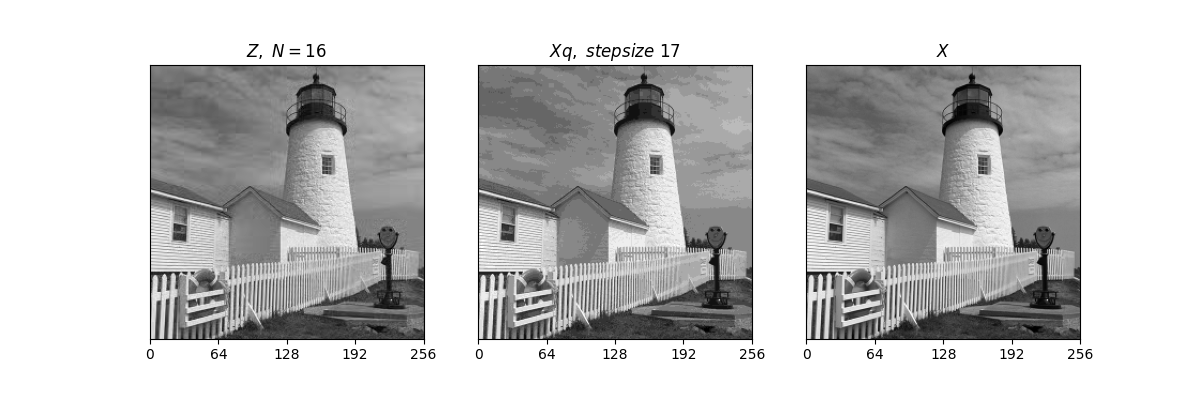

In [21]:
Y = colxfm(colxfm(X, C16).T, C16).T

N = 16


def f(step_size):
    Z = colxfm(colxfm(quantise(Y, step_size).T, C16.T).T, C16.T)
    return abs(np.std(X-Xq)-np.std(X-Z))

decimal_range = np.arange(0, 40, 0.1)
optimal_step = -1
smallest_diff = 10e15

for i in decimal_range:
    # print(i,"             ",abs(f(i)))
    if f(i) < smallest_diff:
        smallest_diff = f(i)
        optimal_step = i

print("optimal_step",optimal_step)
Y_q = quantise(Y,optimal_step)
Yr=regroup(Y_q, N)/N  #Yr is from quantised
print("total bits using dctbpp",dctbpp(Yr,N))

compression_ratio = X_q_total_bits/(dctbpp(Yr,N)) #Yr is quantised
print("compression ratio",compression_ratio)

Z = colxfm(colxfm(Y_q.T, C16.T).T, C16.T)

titles = ["Z,\ N=16","Xq,\ stepsize\ 17","X"]
imgs = [Z,X_q,X]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), #12 is width
                        gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs]))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

compression_ratio_dict[N] = compression_ratio
compression_ratio_dctN_fixed[N] = X_q_total_bits/(dctbpp(Yr,8))


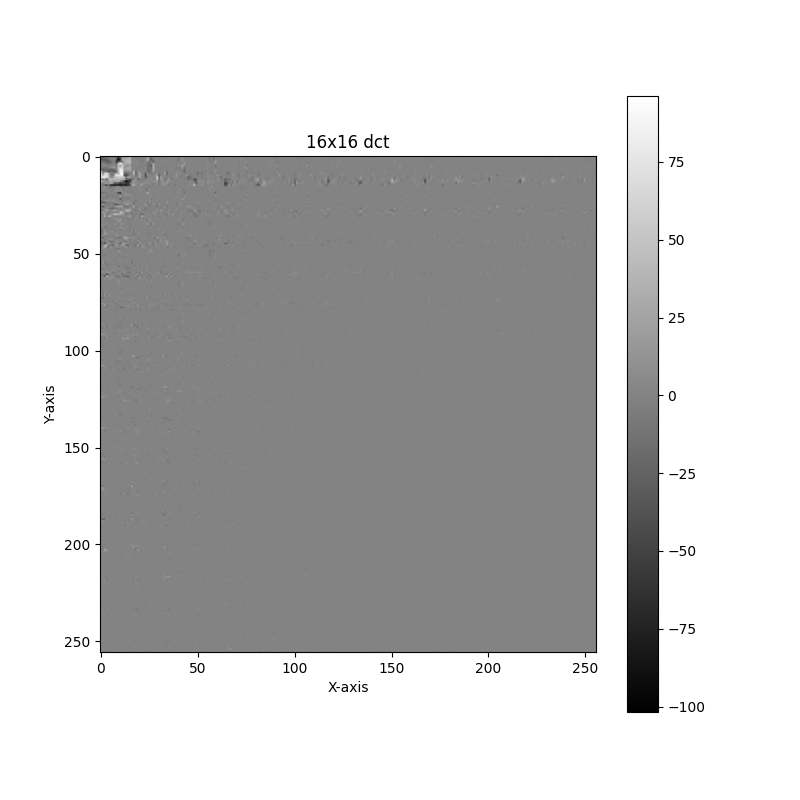

In [22]:
# Plotting the 2D NumPy array as an image
plt.figure(figsize=(8, 8))
plt.imshow(Yr, cmap='gray', aspect='equal')
plt.colorbar()  # Show color scale
plt.title('16x16 dct')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


This analysis is in fact slightly biased because with larger transform sizes the function `dctbpp(Yr, N)` will use a greater number of smaller sub-images on which to calculate probability distributions. It may be better to use the same N in this function even when the actual transform changes; however whether this is more predictive of actual coding performance depends on what scanning method is used in the coding scheme.

<div class="alert alert-block alert-danger">

What happens in the limit if you use `dctbpp(Yr, 256)` (i.e. the entropy is calculated independently for each pixel)? Why is this the case, and why isn't this a realistic result?</div>

In [23]:
# Your code here

print("total bits using dctbpp",dctbpp(Yr,256))

"""
TODO
not realistic to be 0. 
each image is split into 256*256 sub images, and the entropy of a 1x1 image is 0?
is there any issue with it being 0?

dctbpp N=8 is more fair. larger n reduces entropy of sub images but grows the header size. we will look at compression later. here 
TODO calculate compression ratio using equal N for dct bpp

"""


total bits using dctbpp 0.0


'\nTODO\nnot realistic to be 0. \neach image is split into 256*256 sub images, and the entropy of a 1x1 image is 0?\nis there any issue with it being 0?\n\ndctbpp N=8 is more fair. larger n reduces entropy of sub images but grows the header size. we will look at compression later. here \nTODO calculate compression ratio using equal N for dct bpp\n\n'

<div class="alert alert-block alert-danger">

Can you draw any conclusions about the best choice of transform size for the
Lighthouse image?  Try to postulate what features in other images might make your
conclusions different, and suggest why.</div>

Compression ratio:
4: 2.6457199497483272
8: 2.943203081702647
16: 2.877945062159845
Compression ratio dct N fixed:
4: 2.874577575863722
8: 2.943203081702647
16: 2.8037407132283843


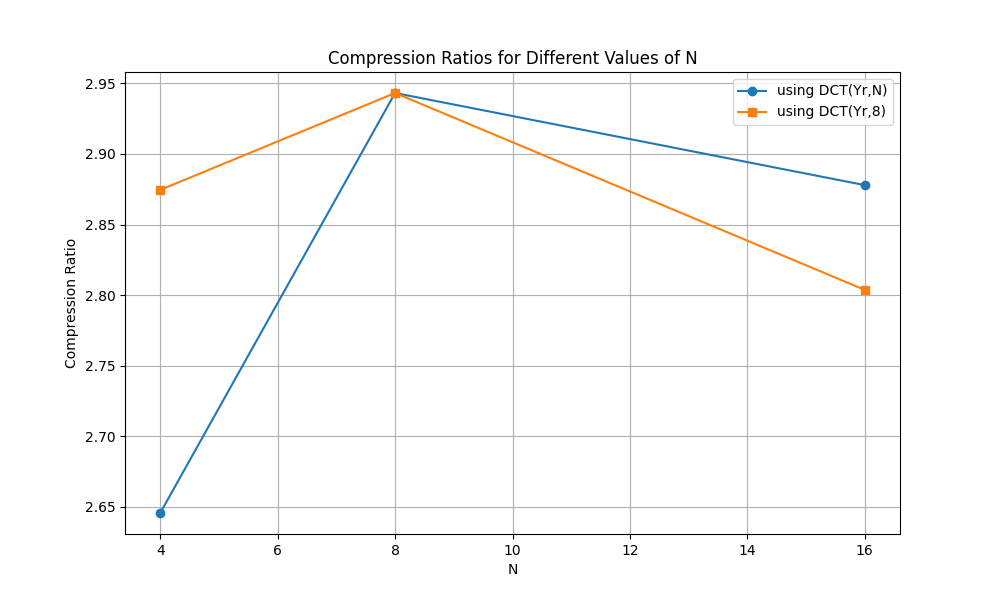

In [24]:
# Your code here

# Sort the dictionary by key
sorted_keys = sorted(compression_ratio_dict.keys())
sorted_keys_Nfixed = sorted(compression_ratio_dctN_fixed.keys())

# Print the dictionary sorted by key
print("Compression ratio:")
for key in sorted_keys:
    print(f"{key}: {compression_ratio_dict[key]}")

print("Compression ratio dct N fixed:")
for key in sorted_keys_Nfixed:
    print(f"{key}: {compression_ratio_dctN_fixed[key]}")


"""
8 is best. if another image has less fine detail, maybe a larger block of 16 might be most efficient. example could be picture of clouds

TODO plot compression ratio for constant dctbpp N, variable dctbpp N against 4,8,16

"""

# Sorting the dictionaries by keys
sorted_N_values = sorted(compression_ratio_dict.keys())

# Extracting the sorted values
ratios_dict = [compression_ratio_dict[N] for N in sorted_N_values]
ratios_dctN_fixed = [compression_ratio_dctN_fixed[N] for N in sorted_N_values]

# Plotting the compression ratios
plt.figure(figsize=(10, 6))
plt.plot(sorted_N_values, ratios_dict, marker='o', label='using DCT(Yr,N)')
plt.plot(sorted_N_values, ratios_dctN_fixed, marker='s', label='using DCT(Yr,8)')

# Adding titles and labels
plt.title('Compression Ratios for Different Values of N')
plt.xlabel('N')
plt.ylabel('Compression Ratio')
plt.legend()
plt.grid(True)
plt.show()